# Motorbike Ambulance Calls - Analysis

## Task description

Motorbike accidents and subsequent ambulance calls are highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the events.
The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


The challenge consists in:

1) conducting an explorative data analysis, and

2) setting up a prediction model for the parameter “cnt”


### Dataset description:

	- index: record index
	- date : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : whether day is holiday or not
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- cnt: count of total ambulance calls


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn import model_selection

In [47]:
batch_size = 100
epochs = 50

In [48]:
df = pd.read_excel('Motorbike-Ambulance-Calls-Dataset/motorbike_ambulance_calls.xlsx')
df.head()

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,spring,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,spring,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [49]:
def update_one_hot(df,upto):
    for i in range (len(df)-1):
        for j in range (upto):
            #print (i,j)
            #print (df.iloc[i],df.iloc[j])
            if df.iloc[i][j]==1:
                if j==0:
                    df.iloc[i][j]=2
                    df.iloc[i][j+1]=1
                    df.iloc[i][upto]=1
                    break
                else:
                    if j==upto:
                        df.iloc[i][j]=2
                        df.iloc[i][j-1]=1
                        df.iloc[i][0]=1
                        break
                    else:
                        df.iloc[i][j]=2
                        df.iloc[i][j+1]=1
                        df.iloc[i][j-1]=1
                        break
    return df

In [50]:
def append_to_df (df,df1,value,value1):
    df1.columns = ["hr"+str(i) for i in range(value)]
    df1 = update_one_hot(df1,value1)
    return pd.concat([df,df1], axis=1)

In [52]:
df = append_to_df(df,pd.DataFrame(keras.utils.to_categorical(df["hr"])),24,23)
df = append_to_df(df,pd.DataFrame(keras.utils.to_categorical(df["mnth"])),13,12)
df = append_to_df(df,pd.DataFrame(keras.utils.to_categorical(df["weekday"])),7,4)

#df.drop(['hr'], axis=1)

weathersitdf = pd.DataFrame(keras.utils.to_categorical(df["weathersit"]))
weathersitdf.columns = ["weathersit"+str(i) for i in range(5)]
df = pd.concat([df,weathersitdf], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 64 columns):
index          17379 non-null int64
date           17379 non-null datetime64[ns]
season         17379 non-null object
yr             17379 non-null int64
mnth           17379 non-null int64
hr             17379 non-null int64
holiday        17379 non-null int64
weekday        17379 non-null int64
workingday     17379 non-null int64
weathersit     17379 non-null int64
temp           17379 non-null float64
atemp          17379 non-null float64
hum            17379 non-null float64
windspeed      17379 non-null float64
cnt            17379 non-null int64
hr0            17379 non-null float64
hr1            17379 non-null float64
hr2            17379 non-null float64
hr3            17379 non-null float64
hr4            17379 non-null float64
hr5            17379 non-null float64
hr6            17379 non-null float64
hr7            17379 non-null float64
hr8            17379 non-null

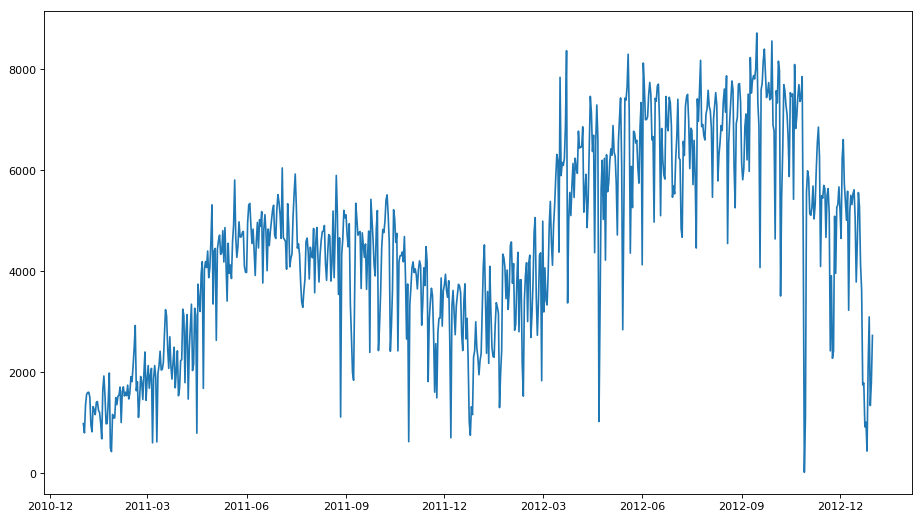

In [53]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df.groupby("date")["cnt"].sum())

## Prediction model

In [54]:
def split_dataset():
    X = (df.drop(['cnt','date','season'], axis=1).as_matrix())
    y = (df[['cnt']].as_matrix())
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [55]:
X_train, X_test, y_train, y_test = split_dataset()

In [56]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=X_train.shape[1:2]))
model.add(Dropout(0.25))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(loss='mse',
               optimizer='adam',
               metrics=['mae'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 13903 samples, validate on 3476 samples
Epoch 1/50
13903/13903 [==============================] - 36s 3ms/step - loss: 52934.6726 - mean_absolute_error: 163.5190 - val_loss: 33385.7192 - val_mean_absolute_error: 136.2643
Epoch 2/50
13903/13903 [==============================] - 0s 31us/step - loss: 35584.6602 - mean_absolute_error: 142.0552 - val_loss: 34071.8810 - val_mean_absolute_error: 136.0133
Epoch 3/50
13903/13903 [==============================] - 0s 30us/step - loss: 35022.4368 - mean_absolute_error: 140.4103 - val_loss: 32242.7275 - val_mean_absolute_error: 134.1184
Epoch 4/50
13903/13903 [==============================] - 0s 31us/step - loss: 33966.5104 - mean_absolute_error: 137.8902 - val_loss: 32706.4600 - val_mean_absolute_error: 129.9805
Epoch 5/50
13903/13903 [==============================] - 0s 30us/step - loss: 31170.4669 - mean_absolute_error: 132.5451 - val_loss: 27140.1553 - val_mean_absolute_error: 116.6155
Epoch 6/50
13903/13903 [======================

13903/13903 [==============================] - 0s 30us/step - loss: 12459.4068 - mean_absolute_error: 75.9457 - val_loss: 12248.3747 - val_mean_absolute_error: 80.6663
Epoch 47/50
13903/13903 [==============================] - 0s 30us/step - loss: 13544.1436 - mean_absolute_error: 79.1730 - val_loss: 10712.9155 - val_mean_absolute_error: 67.3878
Epoch 48/50
13903/13903 [==============================] - 0s 30us/step - loss: 13538.2866 - mean_absolute_error: 79.1052 - val_loss: 9817.6696 - val_mean_absolute_error: 65.9594
Epoch 49/50
13903/13903 [==============================] - 0s 30us/step - loss: 12539.8642 - mean_absolute_error: 75.9424 - val_loss: 10303.4897 - val_mean_absolute_error: 65.8657
Epoch 50/50
13903/13903 [==============================] - 0s 30us/step - loss: 12977.6925 - mean_absolute_error: 77.4703 - val_loss: 12228.4969 - val_mean_absolute_error: 71.4476
Test loss: 12228.497233260214
Test accuracy: 71.44755729789426
